#### Imports

In [1]:
import wrangle
import explore
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

pd.options.display.float_format = '{:20,.2f}'.format

from math import sqrt
from scipy import stats

import warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import StandardScaler, QuantileTransformer, PowerTransformer, RobustScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from statsmodels.formula.api import ols
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score
from sklearn.feature_selection import f_regression, SelectKBest, RFE 
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.cluster import KMeans

#### Import LA Dataframe For Explore

In [2]:
df = wrangle.get_zillow_data(cached=True)
df_la, df_v, df_o = wrangle.clean_zillow_data(df)
X_train, X_validate, X_test, X_train_explore, y_train, y_validate, y_test, X_train_scaled, X_validate_scaled, X_test_scaled = wrangle.split_scale(df_la)

In [3]:
X_train.shape, X_validate.shape, X_test.shape, y_train.shape

((18756, 13), (8039, 13), (6699, 13), (18756, 1))

# Exploration:

**Target = Logerror** 


-A number that represents a ratio that is derived from two prior distributions - the real price distribution of homes and then Zillow's existing model of that distribution

In [4]:
X_train_explore.head()

,logerror,bathroomcnt,calculatedfinishedsquarefeet,latitude,longitude,LA,Orange,Ventura,age,taxrate,acres,structure_dollar_per_sqft,land_dollar_per_sqft,bed_bath_ratio
50028,0.03,3.00,"2,313.00",34.16,-118.42,1,0,0,55.00,0.01,0.16,151.44,72.58,1.33
16721,-0.02,1.00,"1,232.00",34.23,-118.25,1,0,0,91.00,0.01,0.17,18.40,13.69,3.00
30822,0.07,1.00,"1,213.00",34.03,-118.46,1,0,0,66.00,0.01,0.13,91.47,141.76,3.00
4398,0.03,2.00,"1,920.00",34.02,-118.32,1,0,0,95.00,0.01,0.13,62.68,41.50,1.50
46912,-0.01,2.00,"1,268.00",33.91,-118.13,1,0,0,63.00,0.02,0.12,28.23,5.11,1.50


#### Inital Thoughts:

- From my inital investigation on regression project I know that room count has a large affect on taxrate and housing price.  I was unable to create a derived feature last go round so I want to test the affect of this feature now.     

- I want to examine how usefull our created feature of bedbathratio is in predicting logerror in LA County.  I chose LA County because it has the largest number of datapoints.  I want to cluster on bedbathratio, bathroomcnt, and caluculaedfinishedsquarefeet.   

<div class="alert alert-block alert-info"><b></b></div>

## Cluster One: Room Clusters

- bedbathratio   
- bathroomcnt   
- caluculaedfinishedsquarefeet   

In [5]:
X_train_scaled.describe()

,bathroomcnt,calculatedfinishedsquarefeet,latitude,longitude,LA,Orange,Ventura,age,taxrate,acres,structure_dollar_per_sqft,land_dollar_per_sqft,bed_bath_ratio
count,"18,756.00","18,756.00","18,756.00","18,756.00","18,756.00","18,756.00","18,756.00","18,756.00","18,756.00","18,756.00","18,756.00","18,756.00","18,756.00"
mean,0.20,0.08,0.53,0.53,0.00,0.00,0.00,0.45,0.03,0.00,0.06,0.02,0.33
std,0.10,0.05,0.16,0.17,0.00,0.00,0.00,0.17,0.02,0.02,0.04,0.04,0.12
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.18,0.05,0.42,0.40,0.00,0.00,0.00,0.36,0.02,0.00,0.04,0.00,0.27
50%,0.18,0.06,0.51,0.53,0.00,0.00,0.00,0.47,0.02,0.00,0.06,0.01,0.30
75%,0.27,0.09,0.59,0.64,0.00,0.00,0.00,0.53,0.03,0.00,0.08,0.03,0.40
max,1.00,1.00,1.00,1.00,0.00,0.00,0.00,1.00,1.00,1.00,1.00,1.00,1.00


### Step 1. Elbow Plot

   k                  sse
0  1               492.58
1  2               245.24
2  3               152.44
3  4               102.44
4  5                71.00
5  6                59.45
6  7                48.26
7  8                38.27
8  9                31.17


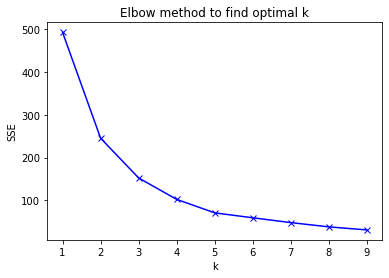

In [6]:
cluster_vars = ['bathroomcnt', 'bed_bath_ratio', 'calculatedfinishedsquarefeet']
explore.elbow_plot(X_train_scaled, cluster_vars)

#### Takeaway:

- Lets try 4 
***

### Step 2. Create Clusters

#### 2a. Train Cluster

In [7]:
train_clusters, kmeans = explore.run_kmeans(X_train, X_train_scaled, k=4, cluster_vars=cluster_vars, cluster_col_name = 'room_cluster')

In [8]:
train_clusters

,room_cluster
50028,3
16721,1
30822,1
4398,3
46912,3
...,...
39988,3
19901,3
51300,3
50259,2


In [9]:
#Visualize distribution of clusters, they do not look even
train_clusters.room_cluster.value_counts()

3    10685
2     4561
1     1957
0     1553
Name: room_cluster, dtype: int64

#### 2b. Get Centroids

In [10]:
# Function that extracts centroids from k-means
centroids = explore.get_centroids(cluster_vars, cluster_col_name='room_cluster', kmeans= kmeans)
centroids

,room_cluster,centroid_bathroomcnt,centroid_bed_bath_ratio,centroid_calculatedfinishedsquarefeet
0,0,0.42,0.20,0.18
1,1,0.09,0.61,0.05
2,2,0.13,0.40,0.05
3,3,0.21,0.27,0.08


#### 2c. Append cluster id onto X_train & X_train_scaled, then join with the centroids dataframe.


In [11]:
# Function that appends Clusters and Centroids to train and validate df
X_train, X_train_scaled = explore.add_to_train(train_clusters, centroids, X_train, X_train_scaled, cluster_col_name = 'room_cluster')

In [12]:
X_train_scaled.head()

,bathroomcnt,calculatedfinishedsquarefeet,latitude,longitude,LA,Orange,Ventura,age,taxrate,acres,structure_dollar_per_sqft,land_dollar_per_sqft,bed_bath_ratio,room_cluster,centroid_bathroomcnt,centroid_bed_bath_ratio,centroid_calculatedfinishedsquarefeet
50028,0.27,0.10,0.55,0.38,0.00,0.00,0.00,0.41,0.02,0.00,0.10,0.04,0.27,3,0.21,0.27,0.08
16721,0.09,0.05,0.60,0.52,0.00,0.00,0.00,0.68,0.02,0.00,0.01,0.01,0.60,1,0.09,0.61,0.05
30822,0.09,0.05,0.47,0.35,0.00,0.00,0.00,0.49,0.02,0.00,0.06,0.08,0.60,1,0.09,0.61,0.05
4398,0.18,0.08,0.46,0.46,0.00,0.00,0.00,0.72,0.02,0.00,0.04,0.02,0.30,3,0.21,0.27,0.08
46912,0.18,0.05,0.38,0.62,0.00,0.00,0.00,0.47,0.03,0.00,0.02,0.00,0.30,3,0.21,0.27,0.08


#### 2d. Visualize room_clusters and centroids 

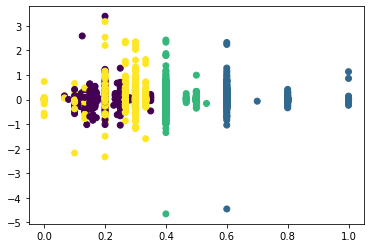

In [13]:
# Visualize 
plt.scatter(X_train_scaled.bed_bath_ratio, y_train.logerror, c=X_train_scaled.room_cluster)
plt.show()

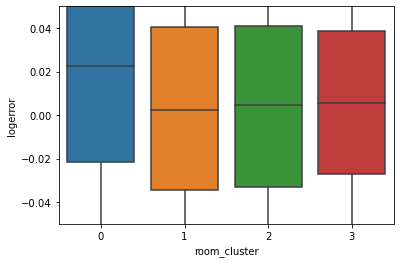

In [14]:
sns.boxplot(X_train_scaled.room_cluster, y_train.logerror)
plt.ylim(-.05,.05)
plt.show()

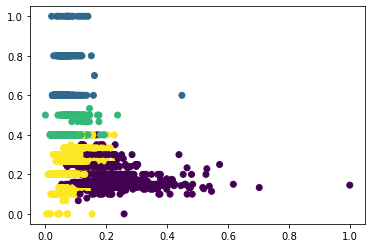

In [15]:
plt.scatter(X_train_scaled.calculatedfinishedsquarefeet, X_train_scaled.bed_bath_ratio, c=X_train_scaled.room_cluster)
plt.show()

<div class="alert alert-block alert-info"><b></b></div>

## Cluster Two: Size Clusters

- calculatedfinishedsquarefeet
- acres
- structure_dollar_per_sqft
- land_dollar_per_sqft

### Step 1. Elbow Plot

   k                  sse
0  1               108.02
1  2                76.69
2  3                62.47
3  4                53.76
4  5                47.30
5  6                41.52
6  7                36.88
7  8                32.90
8  9                30.07


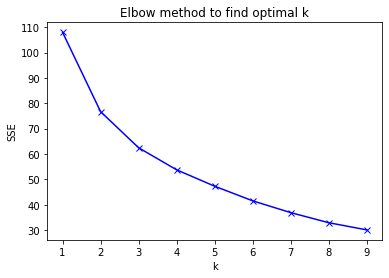

In [16]:
cluster_vars = ['calculatedfinishedsquarefeet', 'acres', 'structure_dollar_per_sqft', 'land_dollar_per_sqft']
explore.elbow_plot(X_train_scaled, cluster_vars)

**Takeaway:**

**K of 3 looks good here**

***

### Step 2. Create Clusters

#### 2a. Train Cluster

In [17]:
train_clusters, kmeans = explore.run_kmeans(X_train, X_train_scaled, k=3, cluster_vars=cluster_vars, cluster_col_name = 'size_cluster')

In [18]:
train_clusters

,size_cluster
50028,1
16721,0
30822,0
4398,0
46912,0
...,...
39988,1
19901,0
51300,0
50259,0


In [19]:
#Visualize distribution of clusters, they do not look even
train_clusters.size_cluster.value_counts()

0    14640
1     3619
2      497
Name: size_cluster, dtype: int64

#### 2b. Get Centroids

In [20]:
# Function that extracts centroids from k-means
centroids = explore.get_centroids(cluster_vars, cluster_col_name='size_cluster', kmeans= kmeans)
centroids

,size_cluster,centroid_calculatedfinishedsquarefeet,centroid_acres,centroid_structure_dollar_per_sqft,centroid_land_dollar_per_sqft
0,0,0.06,0.00,0.05,0.02
1,1,0.14,0.00,0.08,0.03
2,2,0.14,0.00,0.22,0.16


#### 2c. Append cluster id onto X_train & X_train_scaled, then join with the centroids dataframe.

In [21]:
# Function that appends Clusters and Centroids to train and validate df
X_train, X_train_scaled = explore.add_to_train(train_clusters, centroids, X_train, X_train_scaled, cluster_col_name = 'size_cluster')

In [22]:
X_train_scaled.head()

,bathroomcnt,calculatedfinishedsquarefeet,latitude,longitude,LA,Orange,Ventura,age,taxrate,acres,...,bed_bath_ratio,room_cluster,centroid_bathroomcnt,centroid_bed_bath_ratio,centroid_calculatedfinishedsquarefeet_x,size_cluster,centroid_calculatedfinishedsquarefeet_y,centroid_acres,centroid_structure_dollar_per_sqft,centroid_land_dollar_per_sqft
50028,0.27,0.10,0.55,0.38,0.00,0.00,0.00,0.41,0.02,0.00,...,0.27,3,0.21,0.27,0.08,1,0.14,0.00,0.08,0.03
16721,0.09,0.05,0.60,0.52,0.00,0.00,0.00,0.68,0.02,0.00,...,0.60,1,0.09,0.61,0.05,0,0.06,0.00,0.05,0.02
30822,0.09,0.05,0.47,0.35,0.00,0.00,0.00,0.49,0.02,0.00,...,0.60,1,0.09,0.61,0.05,0,0.06,0.00,0.05,0.02
4398,0.18,0.08,0.46,0.46,0.00,0.00,0.00,0.72,0.02,0.00,...,0.30,3,0.21,0.27,0.08,0,0.06,0.00,0.05,0.02
46912,0.18,0.05,0.38,0.62,0.00,0.00,0.00,0.47,0.03,0.00,...,0.30,3,0.21,0.27,0.08,0,0.06,0.00,0.05,0.02


#### 2d. Visualize room_clusters and centroids 

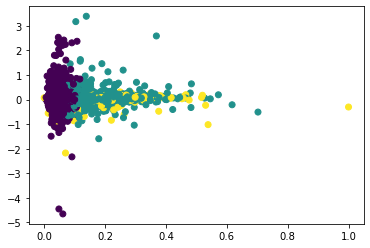

In [23]:
plt.scatter(X_train_scaled.calculatedfinishedsquarefeet, y_train.logerror, c=X_train_scaled.size_cluster)
plt.show()

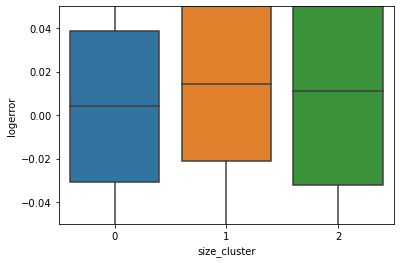

In [24]:
sns.boxplot(X_train_scaled.size_cluster, y_train.logerror)
plt.ylim(-.05,.05)
plt.show()

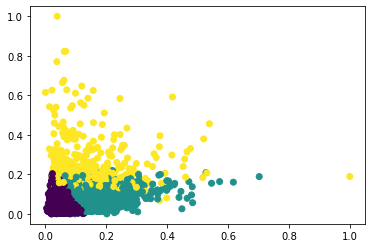

In [25]:
plt.scatter(X_train_scaled.calculatedfinishedsquarefeet, X_train_scaled.structure_dollar_per_sqft, c=X_train_scaled.size_cluster)
plt.show()

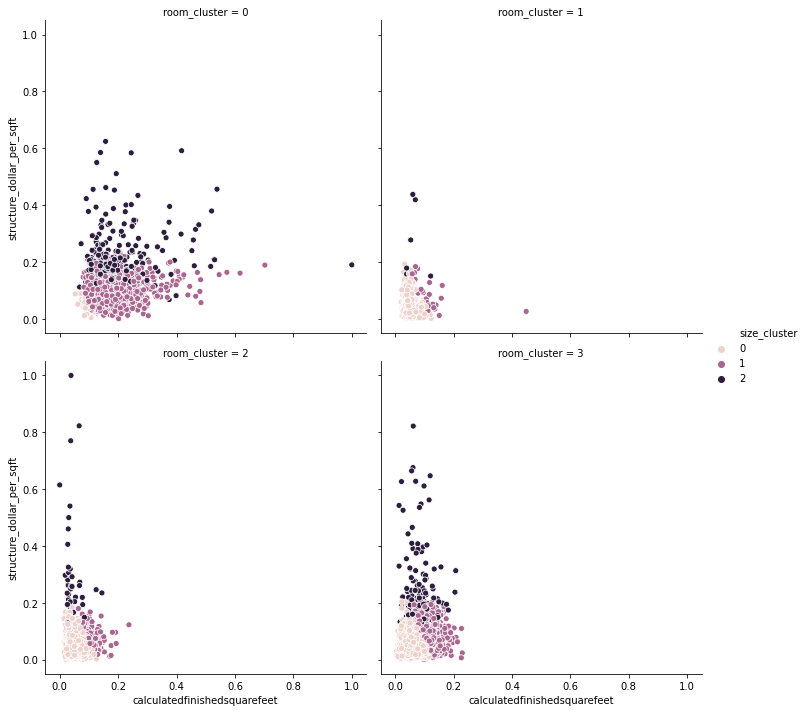

In [26]:
# visualize w/ hue="species" style="cluster"
sns.relplot(x="calculatedfinishedsquarefeet", y="structure_dollar_per_sqft", hue="size_cluster", col="room_cluster", col_wrap=2, data=X_train_scaled)
plt.show()

<div class="alert alert-block alert-info"><b></b></div>

## Cluster Three: Location Clusters (Location plus 2 created features)

- lattitude
- longitude
- room_cluster
- size_cluster

# Characterizing Clusters 

In [27]:
# Examining First Grouping (Room Cluster) Characteristics
X_train_scaled.groupby(['room_cluster'])['calculatedfinishedsquarefeet', 
                                 'bathroomcnt', 
                                  'bed_bath_ratio'].agg(['mean', 'median', 
                                               'std', 'min', 'max'])

calculatedfinishedsquarefeet                       \
                                     mean               median   
room_cluster                                                     
0                                    0.18                 0.16   
1                                    0.05                 0.04   
2                                    0.05                 0.05   
3                                    0.08                 0.07   

                                                                             \
                              std                  min                  max   
room_cluster                                                                  
0                            0.07                 0.05                 1.00   
1                            0.02                 0.02                 0.45   
2                            0.02                 0.00                 0.24   
3                            0.03                 0.00                 0.23   

                      bathroomcnt                                            \
                             mean               median                  std   
room_cluster                                                                  
0                            0.42                 0.36                 0.09   
1                            0.09                 0.09                 0.01   
2                            0.13                 0.09                 0.05   
3                            0.21                 0.18                 0.05   

                                                             bed_bath_ratio  \
                              min                  max                 mean   
room_cluster                                                                  
0                            0.27                 1.00                 0.20   
1                            0.00                 0.27                 0.61   
2                            0.09                 0.27                 0.40   
3                            0.09                 0.36                 0.27   

                                                                             \
                           median                  std                  min   
room_cluster                                                                  
0                            0.20                 0.04                 0.00   
1                            0.60                 0.06                 0.60   
2                            0.40                 0.02                 0.40   
3                            0.30                 0.05                 0.00   

                                   
                              max  
room_cluster                       
0                            0.40  
1                            1.00  
2                            0.53  
3                            0.40

**Takeaway:**   
Cluster 0 - low bed_bath_ratio (lots of bedrooms and lots of bathrooms)    
**1:1**   
Cluster 1 - large bed_bath_ratio (Many bedrooms, few to one bathroom)        
**3:1**   
Cluster 2 - med bed_bath_ratio (Many bedrooms, more than one bath)           
**2:1**   
Cluster 3 - low bed_bath_ratio (Many bedrooms, lots of bathrooms)            
**1.5:1**   

In [28]:
# Examining Second Grouping (Room Cluster) Characteristics
X_train_scaled.groupby(['size_cluster'])['calculatedfinishedsquarefeet', 
                                 'acres','land_dollar_per_sqft', 
                                  'structure_dollar_per_sqft'].agg(['mean', 'median', 
                                               'std', 'min', 'max'])

calculatedfinishedsquarefeet                       \
                                     mean               median   
size_cluster                                                     
0                                    0.06                 0.06   
1                                    0.14                 0.12   
2                                    0.14                 0.11   

                                                                             \
                              std                  min                  max   
size_cluster                                                                  
0                            0.02                 0.00                 0.13   
1                            0.05                 0.04                 0.70   
2                            0.10                 0.00                 1.00   

                            acres                                            \
                             mean               median                  std   
size_cluster                                                                  
0                            0.00                 0.00                 0.02   
1                            0.00                 0.00                 0.01   
2                            0.00                 0.00                 0.00   

                                                       land_dollar_per_sqft  \
                              min                  max                 mean   
size_cluster                                                                  
0                            0.00                 1.00                 0.02   
1                            0.00                 0.41                 0.03   
2                            0.00                 0.02                 0.16   

                                                                             \
                           median                  std                  min   
size_cluster                                                                  
0                            0.01                 0.02                 0.00   
1                            0.02                 0.03                 0.00   
2                            0.14                 0.13                 0.01   

                                  structure_dollar_per_sqft  \
                              max                      mean   
size_cluster                                                  
0                            0.22                      0.05   
1                            0.23                      0.08   
2                            1.00                      0.22   

                                                                             \
                           median                  std                  min   
size_cluster                                                                  
0                            0.05                 0.03                 0.00   
1                            0.08                 0.03                 0.00   
2                            0.19                 0.12                 0.04   

                                   
                              max  
size_cluster                       
0                            0.20  
1                            0.23  
2                            1.00

**Takeaway**

Cluster 0 - Low Cost Per square foot
**low_cost**
Cluster 1 - Medium Cost Per Squre Foot
**medium_cost**
Cluster 2 - High Cost per squre foot
**high_cost**

In [29]:
#Add new names on X_train
X_train = pd.get_dummies(X_train_scaled,
                           columns=['room_cluster','size_cluster'])